# START HERE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install '/content/drive/MyDrive/BIRDCLEF-2022/timm/pytorch-image-models-master'
!pip install '/content/drive/MyDrive/BIRDCLEF-2022/torchlibrosa-0.0.4-py3-none-any.whl'

Processing ./drive/MyDrive/BIRDCLEF-2022/timm/pytorch-image-models-master
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for timm: filename=timm-0.5.4-py3-none-any.whl size=431993 sha256=17f1312b6f9659371d4afd8f01f81109d01df21f3df28531b8a06e0b53a9d203
  Stored in directory: /root/.cache/pip/wheels/74/93/1d/e11cbd2c728aa49375de1d014456fdd4e12389cba8e1dc50e3
Successfully built timm
Processing ./drive/MyDrive/BIRDCLEF-2022/torchlibrosa-0.0.4-py3-none-any.whl


In [ ]:
!pip install geopandas
!pip install timm
!pip install torchlibrosa

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 40.7 MB/s 
     |████████████████████████████████| 16.7 MB 25.3 MB/s 


In [ ]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import plotly.graph_objects as go
import plotly.express as px
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import librosa
import librosa.display
import IPython.display as ipd


import sklearn
import warnings
warnings.filterwarnings('ignore')


import cv2
import audioread
import logging

import random
import time


import soundfile as sf
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

from contextlib import contextmanager
from pathlib import Path
from typing import Optional

from albumentations.core.transforms_interface import ImageOnlyTransform
from torchlibrosa.stft import LogmelFilterBank, Spectrogram
from torchlibrosa.augmentation import SpecAugmentation
from tqdm import tqdm


In [ ]:
taxonomy = pd.read_csv('/content/drive/MyDrive/BIRDCLEF-2022/BirdCLEFData/eBird_Taxonomy_v2021.csv')

In [ ]:
taxonomy

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN
...,...,...,...,...,...,...,...,...,...
16748,34694,species,slcgro1,Slate-colored Grosbeak,Saltator grossus,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16749,34697,species,bltgro2,Black-throated Grosbeak,Saltator fuliginosus,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16750,34698,spuh,saltat1,saltator sp.,Saltator sp.,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16751,34699,spuh,passer1,passerine sp.,Passeriformes sp.,Passeriformes,NaN,Others,NaN


In [ ]:
meta = pd.read_csv('/content/drive/MyDrive/BIRDCLEF-2022/BirdCLEFData/train_metadata.csv')

In [ ]:
meta

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14847,zebdov,[],"['adult', 'song']",22.6499,120.2872,Geopelia striata,Zebra Dove,Jerome Chie-Jen Ko,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:36,https://www.xeno-canto.org/629769,zebdov/XC629769.ogg
14848,zebdov,[],"['adult', 'sex uncertain', 'song']",1.4168,103.7287,Geopelia striata,Zebra Dove,Kim Chuah Lim,Creative Commons Attribution-NonCommercial-Sha...,4.0,08:00,https://www.xeno-canto.org/642415,zebdov/XC642415.ogg
14849,zebdov,[],"['adult', 'call', 'sex uncertain']",1.4347,103.7043,Geopelia striata,Zebra Dove,Kim Chuah Lim,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:00,https://www.xeno-canto.org/665873,zebdov/XC665873.ogg
14850,zebdov,[],['song'],3.3508,101.2451,Geopelia striata,Zebra Dove,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,2.5,11:15,https://www.xeno-canto.org/666194,zebdov/XC666194.ogg


In [ ]:
print('Number of train samples\n')
print(meta.shape[0])

Number of train samples

14852


In [ ]:
print('Number of primary labels')
print(meta['primary_label'].value_counts())

Number of primary labels
brnowl     500
skylar     500
norcar     500
mallar3    500
houspa     500
          ... 
puaioh       3
layalb       3
akikik       2
crehon       2
maupar       1
Name: primary_label, Length: 152, dtype: int64


In [ ]:
print(meta.columns)

Index(['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude',
       'scientific_name', 'common_name', 'author', 'license', 'rating', 'time',
       'url', 'filename'],
      dtype='object')


In [ ]:
print('Labels')
print(meta['primary_label'].unique())
print(len(meta['primary_label'].unique()))
print('NUMBER OF SAMPLES '+str(len(meta['primary_label'])))

Labels
['afrsil1' 'akekee' 'akepa1' 'akiapo' 'akikik' 'amewig' 'aniani' 'apapan'
 'arcter' 'barpet' 'bcnher' 'belkin1' 'bkbplo' 'bknsti' 'bkwpet' 'blkfra'
 'blknod' 'bongul' 'brant' 'brnboo' 'brnnod' 'brnowl' 'brtcur' 'bubsan'
 'buffle' 'bulpet' 'burpar' 'buwtea' 'cacgoo1' 'calqua' 'cangoo' 'canvas'
 'caster1' 'categr' 'chbsan' 'chemun' 'chukar' 'cintea' 'comgal1' 'commyn'
 'compea' 'comsan' 'comwax' 'coopet' 'crehon' 'dunlin' 'elepai' 'ercfra'
 'eurwig' 'fragul' 'gadwal' 'gamqua' 'glwgul' 'gnwtea' 'golphe' 'grbher3'
 'grefri' 'gresca' 'gryfra' 'gwfgoo' 'hawama' 'hawcoo' 'hawcre' 'hawgoo'
 'hawhaw' 'hawpet1' 'hoomer' 'houfin' 'houspa' 'hudgod' 'iiwi' 'incter1'
 'jabwar' 'japqua' 'kalphe' 'kauama' 'laugul' 'layalb' 'lcspet' 'leasan'
 'leater1' 'lessca' 'lesyel' 'lobdow' 'lotjae' 'madpet' 'magpet1'
 'mallar3' 'masboo' 'mauala' 'maupar' 'merlin' 'mitpar' 'moudov' 'norcar'
 'norhar2' 'normoc' 'norpin' 'norsho' 'nutman' 'oahama' 'omao' 'osprey'
 'pagplo' 'palila' 'parjae' 'pecsan' 'peflov' 

In [ ]:
print('Number of classes')
# print(type(meta['primary_label'].unique()))
print(meta['primary_label'].unique().shape)

Number of classes
(152,)


In [ ]:
meta

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14847,zebdov,[],"['adult', 'song']",22.6499,120.2872,Geopelia striata,Zebra Dove,Jerome Chie-Jen Ko,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:36,https://www.xeno-canto.org/629769,zebdov/XC629769.ogg
14848,zebdov,[],"['adult', 'sex uncertain', 'song']",1.4168,103.7287,Geopelia striata,Zebra Dove,Kim Chuah Lim,Creative Commons Attribution-NonCommercial-Sha...,4.0,08:00,https://www.xeno-canto.org/642415,zebdov/XC642415.ogg
14849,zebdov,[],"['adult', 'call', 'sex uncertain']",1.4347,103.7043,Geopelia striata,Zebra Dove,Kim Chuah Lim,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:00,https://www.xeno-canto.org/665873,zebdov/XC665873.ogg
14850,zebdov,[],['song'],3.3508,101.2451,Geopelia striata,Zebra Dove,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,2.5,11:15,https://www.xeno-canto.org/666194,zebdov/XC666194.ogg


Some more EDA

In [ ]:
meta.isna().sum()

primary_label       0
secondary_labels    0
type                0
latitude            0
longitude           0
scientific_name     0
common_name         0
author              0
license             0
rating              0
time                0
url                 0
filename            0
dtype: int64

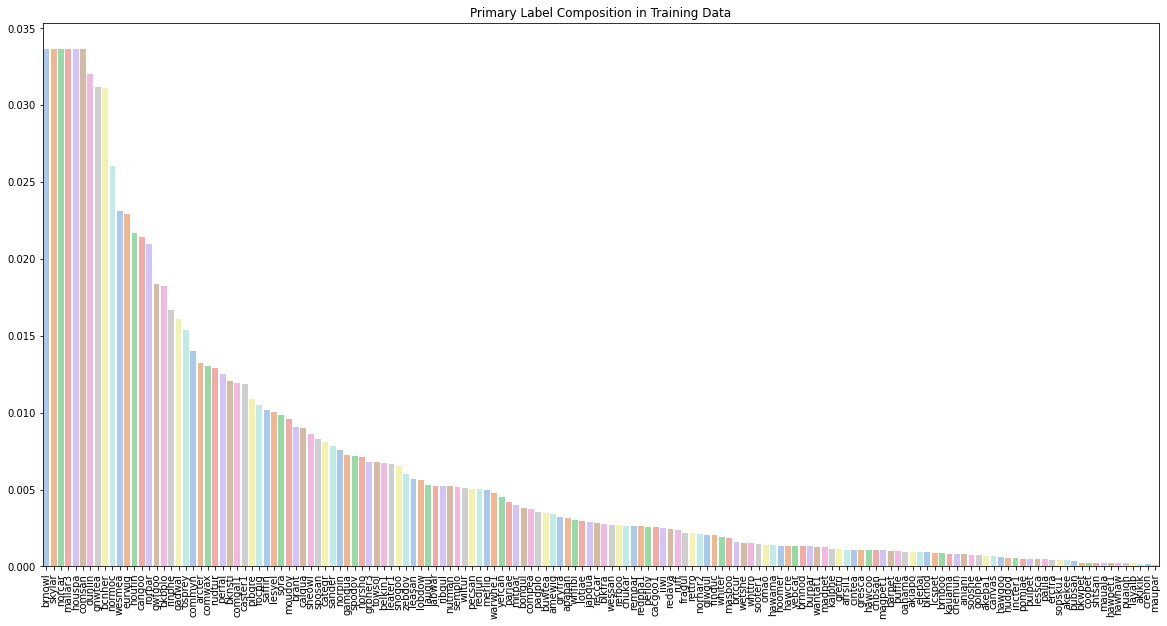

In [ ]:
plt.figure(figsize = (20,10))
colors = sns.color_palette('pastel')
count_val = meta.primary_label.value_counts(normalize = True).values
labels = meta.primary_label.value_counts().keys()
sns.barplot(x = labels,y = count_val, palette  = 'pastel')
plt.xticks(rotation = 90)
plt.title('Primary Label Composition in Training Data')
plt.show()

In [ ]:
fig = px.scatter_geo(
    meta,
    lat="latitude",
    lon="longitude",
    color="common_name",
    width=1_000,
    height=500,
    title="Geographical Locations",
)
fig.show()

In [ ]:
AUDIO_DIR = '/content/drive/MyDrive/BIRDCLEF-2022/BirdCLEFData/train_audio'
idx = np.random.randint(0, len(meta), 10)

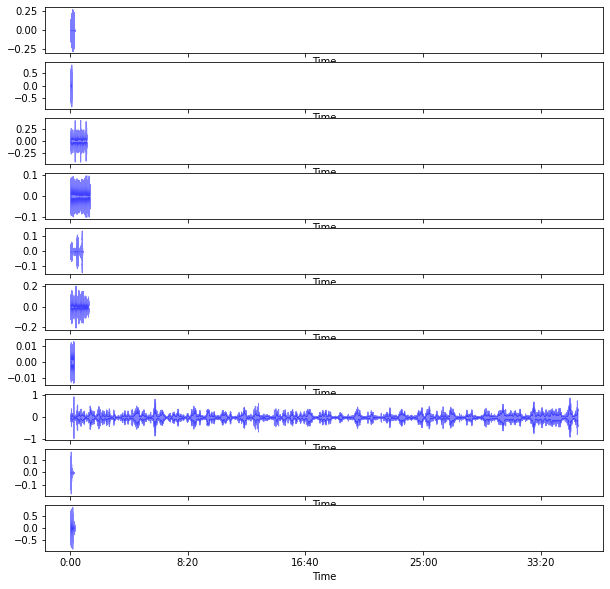

In [ ]:
fig, ax = plt.subplots(nrows=10, figsize=(10, 10), sharex = True)
for i in range(10):
    audio_file = AUDIO_DIR + '/' + meta.iloc[idx[i]].filename
    signal, sr = librosa.load(audio_file)
    librosa.display.waveshow(signal, sr=sr, alpha = 0.5, color = 'blue', ax=ax[i])

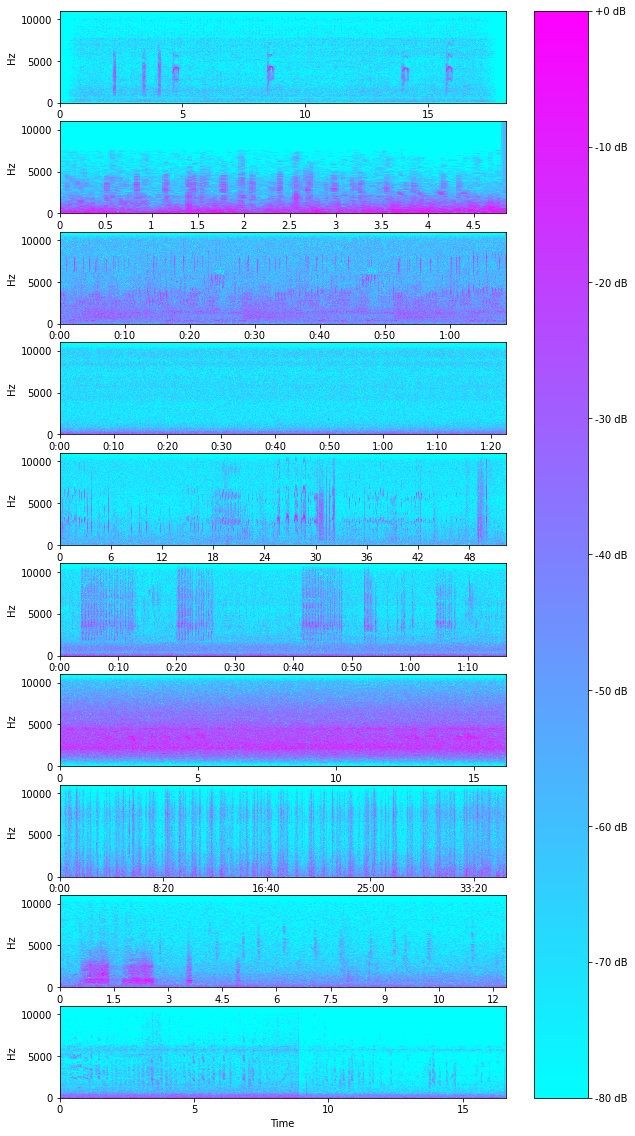

In [ ]:
fig, ax = plt.subplots(nrows=10, figsize=(10, 20))
for i in range(10):
    audio_file = AUDIO_DIR + '/' + meta.iloc[idx[i]].filename
    signal, sr = librosa.load(audio_file)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=sr, ax=ax[i], cmap = 'cool')
fig.colorbar(img, ax=ax, format="%+2.f dB")

Model training

1. Reduce the audio file sizes to 5s
2. Use Librosa to get the spectrograms for each audio file
  >Use the Mel scale for frequency 
  
  >Use the Decibel scale for amplitude





